In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/Users/albertvong/Documents/Argonne/PtychoPINN/')

In [16]:
import numpy as np
import importlib

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset

import lightning as L
import mlflow.pytorch
from mlflow import MlflowClient

from ptycho_torch.dset_loader_pt_mmap import PtychoDataset
from ptycho_torch.model import PtychoPINN
from ptycho_torch.config_params import Params, Config

import matplotlib.pyplot as plt

In this notebook we'll be testing the training of PtychoPINN in Pytorch.

First, we're going to generate a "fake" test dataset using data from /ptycho/datasets/Run1084_recon_postPC_

# Testing out datagen methods

In [6]:
import ptycho_torch.helper as hh
from ptycho_torch.config_params import Params
import ptycho_torch.datagen as dg
import importlib

importlib.reload(hh)

<module 'ptycho_torch.helper' from '/Users/albertvong/Documents/Argonne/PtychoPINN/ptycho_torch/helper.py'>

In [4]:
param_dict = {
    'nphotons': 1e5,
    'N': 128,
}

params = Params()
params.set_settings(param_dict)

In [12]:
output = dg.simulate_from_npz('ptycho_torch/datasets/als128.npy.npz', 2000)

In [26]:
#Save output as npz file in similar location
np.savez('ptycho_torch/datasets/als128_generated.npy.npz',
         diff3d = output['diff3d'],
         xcoords = output['xcoords'],
         ycoords = output['ycoords'],
         xcoords_start = output['xcoords_start'],
         ycoords_start = output['ycoords_start'])


# Testing out tensorloader and model throughput

In [3]:
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader
import ptycho_torch.helper as hh

In [4]:
#Setting probes

#Need better separation of params and configs... confusing
#Could separate into 
#1. Model 
#2. Training
#3. Data

dset_raw = np.load('ptycho_torch/datasets/als128.npy.npz')

probe = dset_raw['probeGuess'][None]
probe = torch.from_numpy(probe)

param_dict = {'probes': probe,
    'nphotons': 1e5,
    'N': 128,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'intensity_scale_trainable': True,
}

params = Params()
params.set_settings(param_dict)


In [5]:
test_dset = PtychoDataset('ptycho_torch/datasets/dummy_data_small', '',remake_map = False)

Existing map found. Loading memory-mapped data


In [6]:
config_dict = {
       'N': 128,
       'offset': 4,
       'gridsize': 2,
       'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
       'n_filters_scale': 2, #Shrinking factor for channels
       'intensity_scale': 15000.0, #General intensity scale guess, this can be trainable. Needs to be float
       'object.big': True, #True if need patch reassembly
       'nll': True #Negative log likelihood for loss function
}

config = Config()
config.set_settings(config_dict)

In [7]:
model = PtychoPINN()

In [8]:
testloader = TensorDictDataLoader(test_dset, batch_size = 64)
#Grab first iter from testloader
test_iter = next(iter(testloader))

#Setting different tensors for model input
diff = test_iter[0]['images']
positions = test_iter[0]['coords_relative']
probe = test_iter[1]
probe32 = probe.to(torch.complex32)

/var/folders/gs/2vxzz2sn2xb79y3v1l6mtp0r0000gn/T/ipykernel_77505/3471003463.py:9: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/EmptyTensor.cpp:45.)
  probe32 = probe.to(torch.complex32)


In [9]:
model.training = True

In [10]:
out = model(diff.to(torch.float32), positions.to(torch.float32), probe32)

tensor([[[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0

In [14]:
model.training = False
out_notrain = model(diff.to(torch.float32), positions.to(torch.float32), probe32)

tensor([[[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0

In [15]:
out_notrain.shape

torch.Size([64, 4, 128, 128])

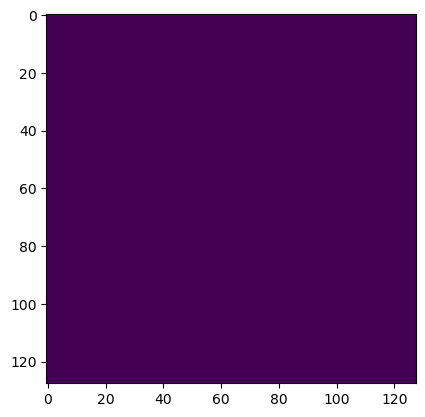

In [18]:
plt.imshow(out_notrain[0][0].detach().angle())